# SmogCasting

**Author: C. Hull** (github: [chat.hull](http://github.com/chathull); personal website: [chathull.com](http://www.chathull.com))

## App

The final product, an AQI forecaster for Santiago, Chile, can be seen at [smogcasting.herokuapp.com](https://smogcasting.herokuapp.com/).

In [2]:
%%javascript

// Prevent scrolling with large/multiple plots
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from ediblepickle import checkpoint
import pickle
import time
import datetime as dt
from datetime import date
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as rmse
from IPython.display import display, Markdown, Latex

# Facebook Prophet modeling
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly

# Helper functions
from smogHelpers import calcAQI, formatDates

# Get nice Seaborn plotting defaults
import seaborn as sns
sns.set()

# altair for interactive plotting
import altair as alt

In [4]:
# Station D14 (Parque O'Higgins; start date: 031216)
station = 'D14'
# Downloaded base datasets for station D14 on 1 June 2022
base_from = '031216'
base_to = '220601'
# Directory where base datasets are located
work_dir = './data/'
# Heroku directory
heroku_dir = '../smog-flask-heroku/static/'
# These dates download the data after 1 June 2022, which will be appended
date_from = '220601'
date_to = date.today().strftime("%y%m%d")

# Base URL, defining sensor station
url1 = f'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/{station}'
# End url, beginning with date range
url2 = f'&from={date_from}&to={date_to}&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
# Sensor-specific URL text
url_sensor = {
    'pm25': '/Cal/PM25//PM25.horario.horario.ic',
    'pm10': '/Cal/PM10//PM10.horario.horario.ic',
    'rhum': '/Met/RHUM//horario_000.ic',
    'temp': '/Met/TEMP//horario_000.ic',
    'wspd': '/Met/WSPD//horario_000.ic',
    'wdir': '/Met/WDIR//horario_000_spec.ic'
}

# Build URL for each observable: 
# Particulate matter (PM2.5 and PM10) and weather data (relative humidity, temperature, wind speed, & wind direction)
sensor_urls = dict([ (key, {'name': key, 'url': url1 + val + url2}) for key,val in url_sensor.items() ])

In [5]:
# Refresh model?
refresh_model = False


## Query SINCA website, format data, and produce final pandas dataframe


In [7]:
def getData(series) :
    time.sleep(1)
    
    # Import PM2.5 or PM10 data
    if series in ['pm25', 'pm10'] :        
        df = pd.read_csv(sensor_urls[series]['url'], 
                         names=['date','time','validated','preliminary','non-validated'], 
                         dtype={'date':str, 'time':str}, 
                         usecols=[0,1,2,3,4], 
                         comment='#', 
                         skiprows=36, 
                         skipfooter=9, 
                         encoding='ISO-8859-1', 
                         engine='python')

    # Import weather data    
    else :
        df = pd.read_csv(sensor_urls[series]['url'], 
                         names=['date','time',sensor_urls[series]['name']], 
                         dtype={'date':str, 'time':str}, 
                         usecols=[0,1,2], 
                         comment='#', 
                         skiprows=32, 
                         skipfooter=5, 
                         encoding='ISO-8859-1', 
                         engine='python')
    
    # Format dates
    df = formatDates(df)

    # Replace white space with NaNs
    df = df.replace(r'^\s+$', np.nan, regex=True)
    
    # For PM2.5 or PM10 data, combine validated, preliminary, and non-validated data columns
    if series in ['pm25', 'pm10'] :
        df[sensor_urls[series]['name']] = df['validated'].combine_first(df['preliminary']).combine_first(df['non-validated'])
        df = df.drop(columns=['validated','preliminary','non-validated'])
    
    # Convert unicode to floats
    df[sensor_urls[series]['name']] = pd.to_numeric(df[sensor_urls[series]['name']])

    # Interpolate missing values; assume default method ('linear')
    df[sensor_urls[series]['name']] = df[sensor_urls[series]['name']].interpolate()

    return df

In [8]:
# Empty DataFrame for all data
df_tot = pd.DataFrame(columns=['datetime'])

# Merge all 6 series into full DataFrame
for series in sensor_urls : 
    # Load base data
    base_file = work_dir+'_'.join([series, base_from, base_to, station])+'.response.pkl'
    with open(base_file, 'rb') as f:
        base = pickle.load(f)
    # Restrict base to midnight on the final day
    base = base[base['datetime'] <= dt.datetime.strptime(base_to, "%y%m%d")]
    # Get new data
    new = getData(series)
    # Concat base data and new data
    df = pd.concat([base,new], ignore_index=True)
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

In [9]:
df_tot.tail(25)

,datetime,pm25,pm10,rhum,temp,wspd,wdir
161830,2022-06-01 23:00:00,13.0,37.0,85.1667,6.29167,0.654297,17.1578
161831,2022-06-02 00:00:00,12.0,31.0,92.5000,5.95000,0.388574,55.6091
161832,2022-06-02 01:00:00,10.0,34.0,94.0004,6.00000,0.338673,193.9330
161833,2022-06-02 02:00:00,18.0,29.0,94.7500,5.88334,0.489347,144.0220
161834,2022-06-02 03:00:00,14.0,27.0,96.1667,5.79167,0.157909,88.9478
161835,2022-06-02 04:00:00,17.0,25.0,97.0004,6.01667,0.091299,129.0430
161836,2022-06-02 05:00:00,14.0,28.0,97.8333,6.08333,0.201516,122.3830
161837,2022-06-02 06:00:00,18.0,35.0,98.0004,5.85834,0.374644,188.4050
161838,2022-06-02 07:00:00,21.0,29.0,98.0004,5.50833,0.305790,168.2890
161839,2022-06-02 08:00:00,24.0,39.0,98.6667,5.85000,0.265586,174.7040


# Fit the Prophet time-series model

In [10]:
today = date.today()

# Strip out ds (datestamp) and pm2.5 (for the y column) for the Prophet prediction
df_prophet = df_tot[['datetime','pm25']]

# Rename columns to comply with Prophet naming requirements
# Prophet requires a df with columns named 'ds' (datestamp) and 'y' (numeric measurement to be forecast)
df_prophet = df_prophet.rename(columns={'datetime':'ds', 'pm25':'y'})

# Train model on all data up to the end of the day yesterday
df_prophet = df_prophet[(df_prophet['ds'] < str(today) )]
df_prophet

,ds,y
0,2003-12-16 01:00:00,29.0
1,2003-12-16 02:00:00,36.0
2,2003-12-16 03:00:00,35.0
3,2003-12-16 04:00:00,27.0
4,2003-12-16 05:00:00,48.0
...,...,...
161826,2022-06-01 19:00:00,19.0
161827,2022-06-01 20:00:00,19.0
161828,2022-06-01 21:00:00,15.0
161829,2022-06-01 22:00:00,12.0


In [11]:
# Model file (either to read from or write to)
model_file = work_dir+'_'.join([base_from, date_to, station])+'.model.pkl'

if refresh_model :
    # Instantiate Prophet model 
    m = Prophet(
        seasonality_mode='additive',
        changepoint_prior_scale=0.01,
    )

    # Fit model (takes 2-3 min for full ~20-year dataset)
    m.fit(df_prophet)

    # Save model
    with open(model_file, 'wb') as f:
            pickle.dump(m, f)
else :
    with open(model_file, 'rb') as f:
        m = pickle.load(f)

# Make a prediction using the Prophet model

In [12]:
# Make future df (predict for 1 week)
# future df is the length of the training set + the length of the prediction period
# Make a long prediction, since the model (trained on almost 20 years of data) changes very little with new data 
N_days = 1095
future = m.make_future_dataframe(periods=N_days*24, freq='H')

# Rename columns to comply with Prophet naming requirements
future = future.rename(columns={'datetime':'ds'})
future

,ds
0,2003-12-16 01:00:00
1,2003-12-16 02:00:00
2,2003-12-16 03:00:00
3,2003-12-16 04:00:00
4,2003-12-16 05:00:00
...,...
188106,2025-05-31 19:00:00
188107,2025-05-31 20:00:00
188108,2025-05-31 21:00:00
188109,2025-05-31 22:00:00


In [13]:
# Model file (either to read from or write to)
forecast_file = work_dir+'_'.join([base_from, date_to, station])+'.forecast.pkl'

if refresh_model :
    # Make forecast (takes 1 minute)
    forecast = m.predict(future)

    # Save forecast
    with open(forecast_file, 'wb') as f:
        pickle.dump(forecast, f)
else :
    with open(forecast_file, 'rb') as f:
        forecast = pickle.load(f)

In [14]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2003-12-16 01:00:00,29.523977,5.717546,52.051926
1,2003-12-16 02:00:00,28.295994,3.961395,52.292016
2,2003-12-16 03:00:00,26.689678,1.395824,50.680623
3,2003-12-16 04:00:00,26.003531,3.429804,50.200260
4,2003-12-16 05:00:00,27.261319,1.699036,51.149043
...,...,...,...,...
188106,2025-05-31 19:00:00,33.279101,1.573712,67.629011
188107,2025-05-31 20:00:00,34.553783,2.179394,67.172323
188108,2025-05-31 21:00:00,35.570986,4.112022,71.355694
188109,2025-05-31 22:00:00,36.493538,6.635368,73.184632


# Make interactive altair plot

In [22]:
# Dates for data
now   = dt.datetime.now()
t_min = str(now - dt.timedelta(100))
t_max = str(now + dt.timedelta(4))
# Plot until now minus 2 hr, because data aren't in real-time
t_max_data = str(now - dt.timedelta(hours=2))

# Date range (select from forecast)
dates_model = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] < t_max)]
# Predictions for the next 4 days
values_model = forecast['yhat'][(forecast['ds'] > t_min) & (forecast['ds'] < t_max)]
# Convert to AQI
values_model = values_model.apply(calcAQI)
# Make sure the model never goes below zero
values_model = values_model.clip(0)
# Select data
data = df_tot['pm25'][(df_tot['datetime'] > t_min) & (df_tot['datetime'] < t_max_data)]
# Converto to AQI
data = data.apply(calcAQI)

In [23]:
# Dates for plotting
now   = dt.datetime.now()
t_min = str(now - dt.timedelta(1))
t_max = str(now + dt.timedelta(1))

source = pd.DataFrame({
  'Forecast': values_model,
  'Past data': data,
  'time': dates_model
})

# Colors
domain = ['Forecast', 'Past data']
range_ = ['mediumslateblue', 'darkslategray']

# Tooltips
tooltips = [
    alt.Tooltip('value', title='AQI', format='d'),
    alt.Tooltip('time', title='Time', format=("%a, %b %d, %H:00")),
    alt.Tooltip('variable', title='Series'),
]

# Combine 2 data/forecast streams into 1 column for altair
source = source.melt('time')

# Make legend points
points = alt.Chart(source).mark_circle(size = 0).encode(color = 'variable')

lines = alt.Chart(source).mark_line().encode(
    alt.X(
        shorthand='time', 
        title='', 
        scale=alt.Scale(domain=[t_min, t_max]), 
        axis=alt.Axis(
            format=("%b %d, %H:00"), 
            labelAngle=-45
        )
    ),
    alt.Y(
        shorthand='value', 
        title='Air Quality Index (AQI)',
        scale=alt.Scale(domain=[0,max(max(values_model),max(data))]), 
    ),
    alt.Color(
        shorthand='variable', 
        scale=alt.Scale(domain=domain, range=range_),
        title='Series', 
        legend=alt.Legend(
            title='Series', 
            titleFontSize=12, 
            labelFontSize=12, 
            titleColor='gray', 
            labelColor='gray'
        )
    ),
    strokeWidth=alt.value(3),
    tooltip=tooltips
).interactive(bind_y=False) # Don't automatically zoom along the y-axis

alpha=0.3
band50 = (alt.Chart(pd.DataFrame({'y': [0], 'y2':[50]}))
         .mark_rect(color='green', opacity=alpha)
         .encode(y='y', y2='y2'))
band100 = (alt.Chart(pd.DataFrame({'y': [50], 'y2':[100]}))
         .mark_rect(color='yellow', opacity=alpha)
         .encode(y='y', y2='y2'))
band150 = (alt.Chart(pd.DataFrame({'y': [100], 'y2':[150]}))
         .mark_rect(color='orange', opacity=alpha)
         .encode(y='y', y2='y2'))
band200 = (alt.Chart(pd.DataFrame({'y': [150], 'y2':[200]}))
         .mark_rect(color='red', opacity=alpha)
         .encode(y='y', y2='y2'))
band300 = (alt.Chart(pd.DataFrame({'y': [200], 'y2':[300]}))
         .mark_rect(color='purple', opacity=alpha)
         .encode(y='y', y2='y2'))

chart = band50 + band100 + band150 + band200 + band300 + lines + points

chart_final = chart.configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    titleFontWeight='normal',
    labelColor='gray',
    titleColor='gray'
)

chart_final.save(heroku_dir+'aqi.json')

In [24]:
chart_final

alt.LayerChart(...)

## The seasonalities fit by the model reveal the following: 

(1) The PM2.5 concentration is decreasing year over year<br>
(2) The AQI gets worse as the week progresses<br>
(3) The AQI is worse in the winter (Jun-Aug in the southern hemisphere)<br>
(4) the AQI is best around 16:00 local time

/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


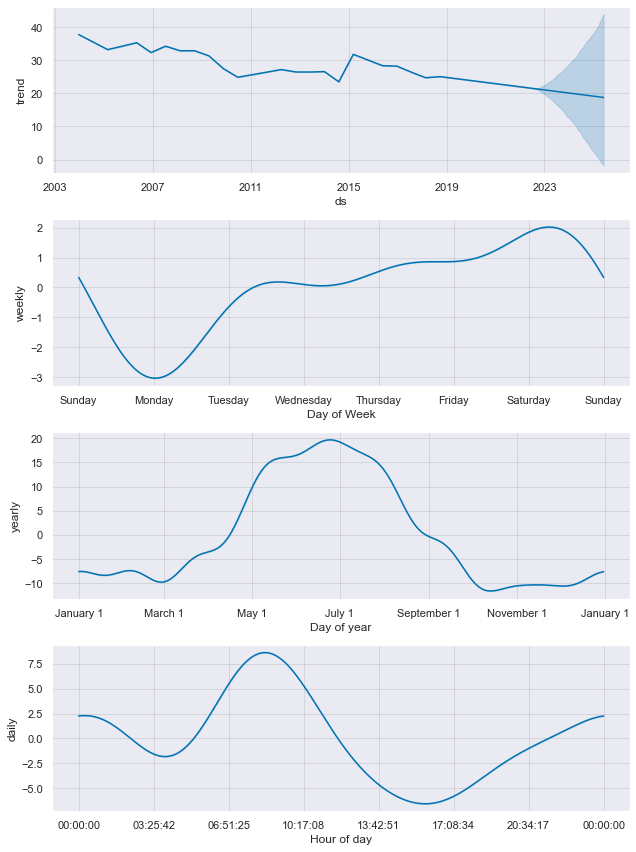

In [18]:
fit2 = m.plot_components(forecast)